## RLlib continued
<!-- video shot="/m0vvzw9o_6U" start="15:22" end="29:05" -->

In [4]:
# HIDDEN
import gym
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

In [5]:
# HIDDEN
import ray
import logging
ray.init(log_to_driver=False, ignore_reinit_error=True, logging_level=logging.ERROR) # logging.FATAL

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [6]:
# HIDDEN
from ray.rllib.algorithms.ppo import PPO, PPOConfig

#### RLlib features

- So far we've seen training, evaluation, and "prediction" with RLlib.
- Next we'll explore a few more features:
   - Algorithm configs
   - Saving/restoring models
   - Interpreting stochastic policies

#### Algorithm configs

Remember this code?

```python
from ray.rllib.algorithms.ppo import PPO, PPOConfig
ppo = PPO(env="FrozenLake-v1", config=ppo_config)
```

Previously, we hid the `ppo_config`. Now we'll delve into it.

In [7]:
ppo_config = PPOConfig()

In [8]:
# HIDDEN - this shows up in module 5 instead
# The number of options is way too many to read:
# len(ppo_config.to_dict())
# # ppo_config.to_dict()

#### Algorithm configs

- When we instantiate a `PPOConfig()` we get the default config values.
- There are a few values that we changed:

In [9]:
ppo_config = ppo_config.framework("torch")

⬆️ Changes the framework from tensorflow (default) to pytorch for the policy model.

In [10]:
ppo_config = ppo_config.debugging(seed=0, log_level="ERROR")

⬆️ Sets a random seed for reproducibility of the course, reduces the warnings displayed.

In [11]:
ppo_config = ppo_config.training(model={"fcnet_hiddens" : [32, 32]})

⬆️ Sets the policy neural network to have a smaller-than-default architecture, which helps the course materials run faster.

In [12]:
ppo_config = ppo_config.rollouts(create_env_on_local_worker=True)

⬆️ This relates to Ray, which we will touch on briefly in Module 5, but skip for now.

In [13]:
ppo_config = ppo_config.environment(env_config={"is_slippery" : False})

⬆️ This is how we set env parameters, in this case specifying the non-slippery Frozen Lake.

Notes:

Remember, the policy is a function from observations to actions, and this function is a neural network. That is why we need a deep learning framework like pytorch.

The random seed is only for the algorithm itself, e.g. randomness in the neural network optimization. It doesn't set the random seed for the environment's own randomness. 

#### Algorithm configs

We can also generate this config in one giant line of Python as follows:

In [14]:
ppo_config = (
    PPOConfig()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32, 32]})
    .environment(env_config={"is_slippery" : False})
)

Notes:

We'll discuss tuning in Module 5.

In [15]:
# HIDDEN
algo_config = (
    PPOConfig()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32, 32]})
    .environment(env_config={"is_slippery" : False})
)

#### Building an algorithm from the config

We previously instantiated our PPO algorithm like this:

In [13]:
ppo = PPO(env="FrozenLake-v1", config=ppo_config)

Using the algorithm config object, we can build the algorithm object like this:

In [14]:
ppo = ppo_config.build(env="FrozenLake-v1")

You can also specify the environment in the config rather than as an argument to `build` (latest syntax):

In [15]:
ppo_config = ppo_config.environment(env="FrozenLake-v1")

ppo = ppo_config.build()

#### The whole config including the environment

Here's what it looks like:

In [ ]:
ppo_config = (
    PPOConfig()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32, 32]})
    .environment(env="FrozenLake-v1", env_config={"is_slippery" : False})
) #                ^ specifying the env

In [ ]:
# HIDDEN - take the env back out
algo_config = (
    PPOConfig()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32, 32]})
    .environment(env_config={"is_slippery" : False})
)

#### Saving models

- We may want to save trained agents for future use.
- This is also called _checkpointing_, especially when done during a training loop.
- In RLlib, this can be done simply with:

```python
algo.save(path_to_checkpoint)
```

It can then be later restored with

```python
algo.restore(path_to_checkpoint)
```

Just make sure you create the algorithm object with the same environment and parameters when restoring from a checkpoint.

In [16]:
# HIDDEN

#### Restoring models

# Let's restore an agent from a checkpoint (created previously):

In [17]:
# # HIDDEN
# ppo_config = (
#     PPOConfig()\
#     .framework("torch")\
#     .rollouts(create_env_on_local_worker=True)\
#     .debugging(seed=0, log_level="ERROR")\
#     .training(model={"fcnet_hiddens" : [32, 32]})
#     .environment(env_config={"is_slippery" : True})\
#     .evaluation(evaluation_config = {"explore" : False})
# )

# ppo = ppo_config.build("FrozenLake-v1")

In [18]:
# # HIDDEN
# for i in range(30):
#     ppo.train()

# ppo.save("models/FrozenLakeSlippery-3232-Ray2-2")

In [19]:
# # HIDDEN
# ppo_config = (
#     PPOConfig()\
#     .framework("torch")\
#     .rollouts(create_env_on_local_worker=True)\
#     .debugging(seed=0, log_level="ERROR")\
#     .training(model={"fcnet_hiddens" : [32, 32]})
#     .environment(env_config={"is_slippery" : True})\
#     .evaluation(evaluation_config = {"explore" : False})
# )

# ppo = ppo_config.build("FrozenLake-v1")

In [20]:
# # HIDDEN
# for i in range(60):
#     ppo.train()

# ppo.save("models/FrozenLakeSlippery-3232-Ray2")

In [21]:
# HIDDEN
#ppo.restore("models/FrozenLakeNonSlippery-3232-Ray2-2/checkpoint_000030")

In [22]:
# HIDDEN 
#ppo.compute_single_action(2)

#### Viewing stochastic policies

- If we want to see what a policy does, we can use `compute_single_action`
- But, some RL algorithms, including PPO, learn _stochastic policies_.
- We may wish to look at these _action probabilities_.

In [23]:
# HIDDEN
import utils

In [24]:
env = gym.make("FrozenLake-v1", is_slippery=False)

In [25]:
probs = utils.query_policy(ppo, env, obs=0)
probs

array([0.2497611 , 0.24977003, 0.2505136 , 0.24995527], dtype=float32)

So far, the probabilities are uniform because the agent has not been trained.

Note that `query_policy` is something written for the course, not a standard RLlib method. See our [course GitHub repo](https://github.com/maxpumperla/rl-course-exercises) for the code.

#### Viewing stochastic policies

Let's restore a previous trained model and try again:

In [26]:
ppo.restore("models/FrozenLakeNonSlippery-3232-Ray2-2/checkpoint_000030")

In [27]:
probs = utils.query_policy(ppo, env, obs=0)
probs

array([3.0708601e-04, 8.6194783e-01, 1.3743131e-01, 3.1362689e-04],
      dtype=float32)

Actions: left (0), down (1), right (2), up (3).

Notes:

Here we can see the agent wanting to move down or right from the upper-left square (observation 0).

#### Viewing stochastic policies

Let's display this a bit more cleanly:

In [28]:
print(f"Left:  {probs[0]*100:5.2f}%")
print(f"Down:  {probs[1]*100:5.2f}%")
print(f"Right: {probs[2]*100:5.2f}%")
print(f"Up:    {probs[3]*100:5.2f}%")

Left:   0.03%
Down:  86.19%
Right: 13.74%
Up:     0.03%


Arena:

```
SFFF
FHFH
FFFH
HFFG
```

Notes:
    
For a continuous action space this would be different.

In [29]:
# HIDDEN
# From the top-left, the agent considers moving left down or right, but not up. Presumably left is preferred to up because slipping down is preferred to slipping right.

#### Viewing stochastic policies

Let's view all the probabilities:

In [30]:
# HIDDEN
import pandas as pd

In [31]:
action_probs = {obs : utils.query_policy(ppo, env, obs) for obs in range(16)}
action_probs_df = pd.DataFrame(action_probs, index=["left", "down", "right", "up"]).T
action_probs_df

,left,down,right,up
0,0.000307,0.861948,0.137431,0.000314
1,0.001545,0.000129,0.997325,0.001000
2,0.000614,0.997883,0.000648,0.000855
3,0.021768,0.002684,0.961310,0.014238
4,0.000100,0.999648,0.000107,0.000145
5,0.008260,0.198169,0.786407,0.007165
6,0.000059,0.999218,0.000640,0.000084
7,0.041046,0.286452,0.634076,0.038426
8,0.000334,0.000075,0.999394,0.000197
9,0.000094,0.029428,0.970416,0.000063


Notes:

Before we were only looking at observation 0, i.e. the first row of the above table.

#### Viewing stochastic policies

We can also view this as an image:

In [32]:
# HIDDEN
# df = pd.DataFrame(action_probs, index=["left", "down", "right", "up"]).T
# plt.figure(figsize=(8,4))
# plt.imshow(df.values.T)
# plt.yticks(np.arange(4), labels=["left", "down", "up", "right"])
# plt.xticks(np.arange(16), labels=np.arange(16))
# plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")
# plt.xlabel("observations")
# plt.ylabel("actions")
# plt.colorbar(location="bottom")
# plt.tight_layout()

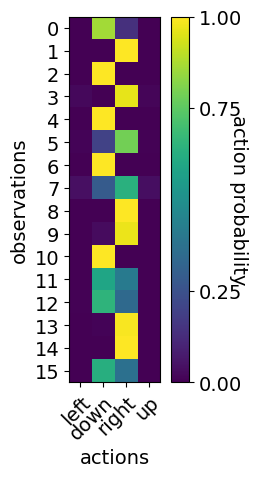

In [33]:
utils.plot_action_probs(action_probs)

See how the agent only moves down and right in the non-slippery Frozen Lake.

Notes:
    
Note how the agent only moves down and right. This is because we are using the non-slippery frozen lake. In this case, the agent can simply move from the start to the end without anything going wrong. Therefore, there's no need to move up or left.

#### Visualizing action probabilities

We can visualize these action probabilities by overlaying them on the Frozen Lake map:

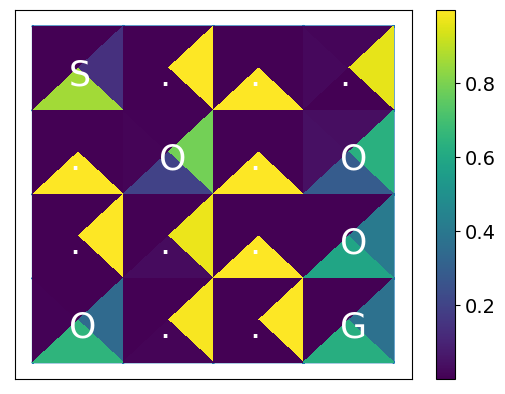

In [34]:
utils.q_state_action_plot_frozenlake(action_probs_df.values, env)

Notes:

Note how the agent often has probabilities very close to 1 (yellow). It clearly wants to walk toward the goal. The probabilities from the hole or goal states are less well defined because the episodes end there. The agent will generally start by moving down but will sometimes move right, which also gets there. 

In Module 4 we'll discuss something called the discount factor, which explains why the agent doesn't like to waste time by walking into the edge of the map.

#### Slippery Frozen Lake

Let's compare the above to the **slippery** Frozen Lake, by restoring an agent trained on that env instead:

In [35]:
ppo_slip = ppo_config.environment(env_config={"is_slippery" : True}).build("FrozenLake-v1")
env_slip = gym.make("FrozenLake-v1", is_slippery=True)

In [38]:
ppo_slip.restore("models/FrozenLakeSlippery-3232-Ray2/checkpoint_000060")

In [39]:
action_probs_slip = {obs : utils.query_policy(ppo_slip, env_slip, obs) for obs in range(16)}
action_probs_slip_df = pd.DataFrame(action_probs_slip, index=["left", "down", "right", "up"]).T

#### Slippery Frozen Lake

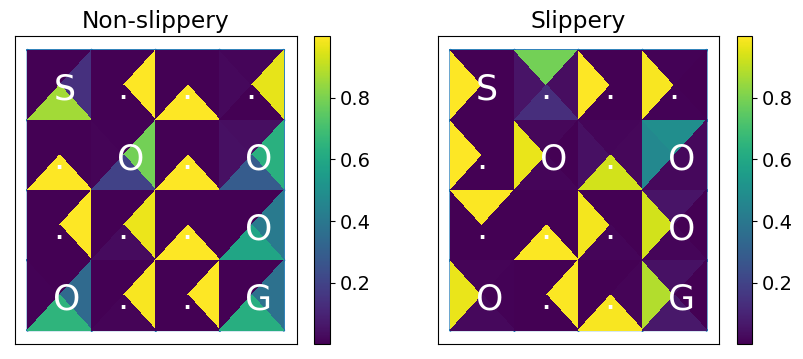

In [41]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
utils.q_state_action_plot_frozenlake(action_probs_df.values, env)
plt.title("Non-slippery")
plt.subplot(1,2,2)
utils.q_state_action_plot_frozenlake(action_probs_slip_df.values, env_slip)
plt.title("Slippery");

Notes:

Let's compare these side-by-side. We previously discussed the non-slippery frozen lake, where the agent walks towards the goal in a simple manner. In the slippery frozen lake the agent behaves unintuitively at first, often electing to walk towards the wall. However, upon closer inspection we see that this is to avoid falling into holes.  For example at location 10 it moves left to avoid any possibility of falling into the hole at location 11. Why does the agent move down at location 14, though? Why not right? We will answer that question in Module 5 when we discuss Q values - stay tuned! The short answer is that it prefers to avoid location 10, because location 10 needs to avoid location 11, which is a hassle because you need to move to location 9. 

We can also see that this agent behaves fairly deterministically - that is, for each state there is usually an action with probability close to 1. Next we'll explore this a bit further.

#### Acting stochastically

- Previously we looked at the action probabilities of our non-slippery agent.
- We can verify that `compute_single_action` will act according to these probabilities:

In [42]:
action_probs[0]

array([3.0708601e-04, 8.6194783e-01, 1.3743131e-01, 3.1362689e-04],
      dtype=float32)

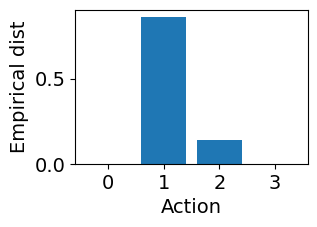

In [43]:
counts = np.bincount([ppo.compute_single_action(0) for _ in range(10_000)])
plt.figure(figsize=(3,2))
plt.bar([0,1,2,3], counts/10_000)
plt.xticks([0,1,2,3]); plt.xlabel("Action"); plt.ylabel("Empirical dist");

#### Acting deterministically

We can also tell the agent to act deterministically with `explore=False`:

In [44]:
ppo.compute_single_action(0, explore=False)

1

In [45]:
print([ppo.compute_single_action(0, explore=False) for _ in range(100)])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Often this is desirable, but **sometimes the optimal policy is stochastic**.

Notes:

During training, exploration is a fundamental concept in RL. We will discuss it in Module 4!

In Module 4 we'll also see an example where the optimal policy is stochastic, so we would definitely not want to set `explore=False` in deployment.

#### Let's apply what we learned!

## RLlib config syntax
<!-- multiple choice -->

Which of the following is **NOT** correct RLlib syntax for instantiating a PPO algorithm instance? Assume the following import has already been run:

```python
from ray.rllib.algorithms.ppo import PPO, PPOConfig
```

- [ ] `PPOConfig().build(env='FrozenLake-v1')`
- [ ] `PPOConfig().environment(env='FrozenLake-v1').build()`
- [x] `PPOConfig(env='FrozenLake-v1').build()`
- [ ] `PPO(env='FrozenLake-v1')`

In [46]:
# # HIDDEN - TO TEST THE ABOVE QUESTION
# from ray.rllib.algorithms.ppo import PPO, PPOConfig

# PPOConfig().framework("torch").build(env="FrozenLake-v1")
# PPOConfig().framework("torch").environment(env="FrozenLake-v1").build()
# PPO(env="FrozenLake-v1", config={"framework" : "torch"})
# PPOConfig(env="FrozenLake-v1").framework("torch").build()

## Saving/restoring models
<!-- multiple choice -->

Which of the following is **NOT** a plausible use of saving ("checkpointing") models in RLlib?

- [x] Checkpointing generates cryptocurrency.
- [ ] In a course like this, loading a checkpoint means you don't always have to wait for models to train.
- [ ] Saved models can be stored, shared, copied and/or moved for deployment.
- [ ] Training can be resumed from a checkpoint in case it fails and needs to be restarted.

## Cartpole environment
<!-- coding exercise -->

A famous benchmark environment in RL is the _Cartpole_ environment, in which the agent must balance an [inverted pendulum](https://en.wikipedia.org/wiki/Inverted_pendulum) by applying force on the cart (at the bottom) to keep it stable. More information is available in the gym documentation [here](https://www.gymlibrary.ml/environments/classic_control/cart_pole/).

Complete the code so that it restores the trained model from the checkpoint and then renders the environment with the trained agent.

Note: the code below imports the env `MyCartPole`. This is identical to gym's `'CartPole-v1'` except that the rendering method has been overridden with something that can be displayed inside of this interactive course platform. 

In [47]:
# EXERCISE
import numpy as np
import time
from IPython import display

from envs import MyCartPole
from ray.rllib.algorithms.ppo import PPO, PPOConfig

config = (
    ____()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32,32]})
    .environment(env=MyCartPole)
)

ppo = ____.____()

____.restore("models/CartPole-Ray2/checkpoint_000050")

env = MyCartPole()
obs = env.reset()
done = False
while not done:
    action = ppo.compute_single_action(obs)
    obs, reward, done, _ = env.step(action)

    env.render()
    time.sleep(0.01)

display.clear_output(wait=True)

ppo.stop()

NameError: name '____' is not defined

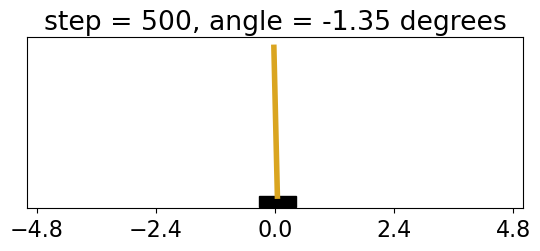

In [1]:
# SOLUTION
import numpy as np
import time
from IPython import display

from envs import MyCartPole
from ray.rllib.algorithms.ppo import PPOConfig

config = (
    PPOConfig()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32,32]})
    .environment(env=MyCartPole)
)

ppo = config.build()

ppo.restore("models/CartPole-Ray2/checkpoint_000050")

env = MyCartPole()
obs = env.reset()
done = False
while not done:
    action = ppo.compute_single_action(obs)
    obs, reward, done, _ = env.step(action)

    env.render()
    time.sleep(0.01)

display.clear_output(wait=True)

ppo.stop()

## Cartpole environment continued
<!-- coding exercise -->

Continuing with the CartPole environment,
in this exercise we'll explore the behavior of the trained agent using the
`utils.query_policy` function from the slides. In the case of CartPole,
the observation space is continuous, but the action space is discrete with only two
possibilities (push left or push right). Therefore, we can look only at the
probability that the agent will push left, since P(right) = 1 - P(left).
The action space contains 4 continuous variables (pole angle, angular velocity,
horizontal cart position, horizontal cart velocity), but we will focus only on
the pole angle. The result is a plot of P(left) vs. pole angle
(where the other three observation values are fixed at zero).
Run the code and then answer the multiple choice question below.

2022-11-19 15:45:52,384	INFO worker.py:1518 -- Started a local Ray instance.
2022-11-19 15:45:55,428	INFO trainable.py:668 -- Restored on 127.0.0.1 from checkpoint: models/CartPole-Ray2/checkpoint_000050
2022-11-19 15:45:55,430	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 110.29570436477661, '_episodes_total': 849}


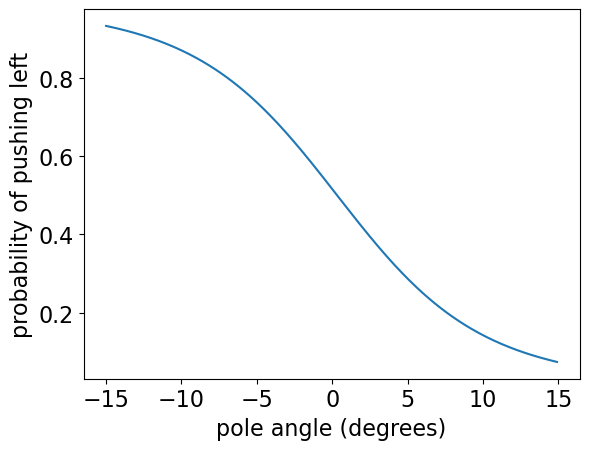

*** SIGTERM received at time=1668901807 ***
PC: @        0x1b6338c20  (unknown)  kevent
[2022-11-19 15:50:07,980 E 99214 25925695] logging.cc:361: *** SIGTERM received at time=1668901807 ***
[2022-11-19 15:50:07,980 E 99214 25925695] logging.cc:361: PC: @        0x1b6338c20  (unknown)  kevent


In [1]:
# EXERCISE
import numpy as np
import matplotlib.pyplot as plt

import utils
from envs import MyCartPole
from ray.rllib.algorithms.ppo import PPOConfig

cartpole_config = (
    PPOConfig()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32, 32]})
    .environment(env=MyCartPole)
)

ppo = cartpole_config.build()

ppo.restore("models/CartPole-Ray2/checkpoint_000050")

angle_range_deg = np.arange(-15,15,0.1)
push_left_probs = 0*angle_range_deg

env = MyCartPole()
obs = env.reset()
for i, angle_deg in enumerate(angle_range_deg):
    angle_rad = angle_deg/180*np.pi
    
    obs = np.zeros(4)
    obs[2] = angle_rad

    push_left_probs[i] = utils.query_policy(ppo, env, obs, actions=[0,1])[0]

plt.plot(angle_range_deg, push_left_probs)
plt.xlabel("pole angle (degrees)")
plt.ylabel("probability of pushing left")

ppo.stop()

#### Interpreting the plot

How does the observed pole angle affect the trained agent's probability of pushing left?

- [ ] Positive pole angles (leaning right) result in the agent being more likely to push the cart left. | Keep in mind that the agent wants to push the cart underneath the top of the pole.
- [x] Negative pole angles (leaning left) result in the agent being more likely to push the cart left.
- [ ] The agent's probability of pushing left is not significantly affected by the pole angle.
- [ ] None of the above.